$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\md}{{\bf D}}
\newcommand{\mP}{{\bf P}}
\newcommand{\mU}{{\bf U}}
\newcommand{\vu}{{\bf u}}
\newcommand{\vx}{{\bf x}}
\newcommand{\vw}{{\bf w}}
\newcommand{\vy}{{\bf y}}
\newcommand{\vf}{{\bf f}}
\newcommand{\vs}{{\bf s}}
\newcommand{\ve}{{\bf e}}
\newcommand{\vd}{{\bf d}}
\newcommand{\vb}{{\bf b}}
\newcommand{\vz}{{\bf z}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mv}{{\bf V}}
\newcommand{\ma}{{\bf A}}
\newcommand{\mi}{{\bf I}}
\newcommand{\mm}{{\bf M}}
\newcommand{\mb}{{\bf B}}
\newcommand{\ball}{{\cal B}}
\newcommand{\ptc}{{\Psi TC}}
\newcommand{\diag}{\mbox{diag}}
\newcommand{\begeq}{{\begin{equation}}}
\newcommand{\endeq}{{\end{equation}}}
$

In [1]:
include("fanote_init.jl")

## Files for this Chapter

- From the Package repository:
  - Solvers for Scalar Equations: __/src/Solvers__
    - Newton's method: __nsol.jl__
    - Pseudo-Transiant continuation: __ptcsol.jl__
  - Test Problems: __/src/TestProblems/Systems__
    - Simple two dimensional prolbem: __simple!.jl__
    - H-equation: __Hequation.jl__
    - Convection-Diffusion equation: __EllipticPDE.jl__ and __PDE\_Tools.jl__
    - Buckling Beam: __FBeam!.jl__
    - Two-point boundary value problem: __Fbvp!.jl__
  - Examples
    - Initial value problem for the Buckling beam: __ivpBeam.jl__
    - Pseudo-transient continuation for the Buckling beam: __ptcBeam.jl__
- From the Notebook repository: __/src/Chapter2__
   - Julia codes that generate the plots and the tables

# Chapter 2: Finding the Newton Step with Gaussian Elimination

## Contents for Chapter 2

[Section 2.1: Direct Methods for Solving Linear Equations](#Section-2.1:-Direct-Methods-for-Solving-Linear-Equations)

[Section 2.2: The Newton-Armijo Iteration](#Section-2.2:-The-Newton-Armijo-Iteration)

[Section 2.3: Computing a Finite Difference Jacobian](#Section-2.3:-Computing-a-Finite-Difference-Jacobian)

[Section 2.4: The Chord and Shamanskii Methods](#Section-2.4:-The-Chord-and-Shamanskii-Methods)

[Section 2.5: What Can Go Wrong?](#Section-2.5:-What-Can-Go-Wrong?)

[Section 2.6: Precomputed and Preallocated Data](#Section-2.6:-Precomputed-and-Preallocated-Data)

[Section 2.7: Five Nonlinear Systems](#Section-2.7:-Five-Nonlinear-Systems)



## Section 2.1: Direct Methods for Solving Linear Equations

Direct methods for solving the equation for the Newton step
are a good idea if

- the Jacobian can be computed and __stored__ efficiently and
- the cost of the factorization of the Jacobian is not excessive or
- iterative methods do not converge for your problem.


Even when direct methods work well,
Jacobian factorization and storage of that
factorization may be more expensive than a solution by iteration.
However, direct methods are more robust than iterative methods and
do not require your worrying about
the possible convergence failure of an iterative method or
preconditioning.

If the linear equation for the Newton step is solved exactly
and the Jacobian is computed and factored with each nonlinear
iteration (i.e., $\eta = 0$ in Algorithm __nsolg__), one should
expect to see q-quadratic convergence until finite-precision
effects produce stagnation (as predicted in __Theorem 1.2__.
One can, of course, approximate the Jacobian or evaluate it only
a few times during the nonlinear iteration, exchanging an increase
in the number of nonlinear iterations for a dramatic reduction in
the cost of the computation of the steps.

In many cases, as we pointed out in [Chapter1](SIAMFANLCh1.ipynb),
one can store and factor $\mf'$ in reduced precision
with no loss in the quality of the solution. If, as we
do in this book, one computes $\mf$ in double precision (Float64), storing
and factoring $\mf'$ in single precision (Float32) cuts the linear algebra
cost in half
<cite data-cite="ctk:sirev20"><a href="siamfa.html#ctk:sirev20">(Kel22)</cite>.
Our solvers enable you to do this with ease by allocating
the storage for $\mf'$ in single precision. We have a detailed example
of this in the notebook.

The Julia codes for the examples in this chapter are in the
[src/Chapter2](src/Chapter2) directory for the notebook. 

In this chapter we solve the equation for the Newton step with
Gaussian elimination. As is standard in numerical linear algebra
(see 
<cite data-cite="golub"><a href="siamfa.html#golub">(GV96)</cite>,
<cite data-cite="stewart"><a href="siamfa.html#stewart">(Ste73)</cite>,
<cite data-cite="trefbau"><a href="siamfa.html#trefbau">(TB96)</cite>,
for example),
we distinguish between the factorization and the solve.
The typical implementation of Gaussian elimination, called
an __LU factorization__,
factors the coefficient matrix
$\ma$ into a product of a permutation matrix and
lower and upper triangular factors:
$$
\ma = \mP \ml \mU.
$$
The factorization may be simpler and less costly if the matrix
has an advantageous structure (sparsity, symmetry, positivity, ...)
<cite data-cite="golub"><a href="siamfa.html#golub">(GV96)</cite>,
<cite data-cite="stewart"><a href="siamfa.html#stewart">(Ste73)</cite>,
<cite data-cite="trefbau"><a href="siamfa.html#trefbau">(TB96)</cite>,
<cite data-cite="demmel"><a href="siamfa.html#demmel">(Dem97)</cite>,
<cite data-cite="linpack"><a href="siamfa.html#linpack">(DMBS79)</cite>,
<cite data-cite="lapack"><a href="siamfa.html#lapack">(ABB<sup>+</sup>92)</cite>.

The permutation matrix reflects row interchanges that are done during
the factorization to improve stability. In Julia the best way to
do this for dense matrices is to factor $\ma$ __in-place__. This means that $\ml$
and $\mU$ are stored by __overwriting__ $\ma$ and the permutation is
recorded in an integer vector. Julia's convention for a function that
overwrites it's input is to put a $!$ after the name of the function.
So you invoke the LU factorization with

```Julia
B = lu!(A).
```

There is a subtle point here that really matters for Newton's method.
While $\mb$ and $\ma$ share storage, they are different data structures.
One can, for example, update $\ma$ as a matrix, as one would do in a
nonlinear solver if $\ma$ is an approximation of the Jacobian. One cannot
do that if one makes the call as

```Julia
A = lu!(A),
```
because then you have changed the data type of $\ma$.

For example, let
$$
\ma = \left(
\begin{array}{ccc}
4 & 6 & 6 \\ 2 & 2 & 3 \\ 7 & 8 & 10
\end{array}
\right)\!.
$$
The LU factorization
```Julia
[l,u]=lu(A)
```
returned by the Julia command is
```Julia
julia> B=lu!(A)
LU{Float64,Array{Float64,2}}
L factor:
3×3 Array{Float64,2}:
 1.00000e+00   0.00000e+00  0.00000e+00
 5.71429e-01   1.00000e+00  0.00000e+00
 2.85714e-01  -2.00000e-01  1.00000e+00
U factor:
3×3 Array{Float64,2}:
 7.00000e+00  8.00000e+00  1.00000e+01
 0.00000e+00  1.42857e+00  2.85714e-01
 0.00000e+00  0.00000e+00  2.00000e-01
```

The permutation is elsewhere in $B$. To see this
```Julia
julia> B.L * B.U
3×3 Array{Float64,2}:
 7.00000e+00  8.00000e+00  1.00000e+01
 4.00000e+00  6.00000e+00  6.00000e+00
 2.00000e+00  2.00000e+00  3.00000e+00
```
Indicating that $\ml \mU = \mP^T \ma$. The permutation vector is
```Julia
julia> B.p
3-element Array{Int64,1}:
 3
 1
 2
```

We use the output of ```lu!``` with the standard backslash notation. So
to solve $\ma \vx = \vb$ one would do this.
```
julia> B=lu!(A);
julia> s=B\b;
```
In the REPL, the semicolon suppresses output, just as it does in Matlab.

We will ignore the permutation for the remainder of this chapter, but
the reader should remember that it is important. Most
linear algebra software
<cite data-cite="lapack"><a href="siamfa.html#lapack">(ABB<sup>+</sup>92)</cite>,
<cite data-cite="linpack"><a href="siamfa.html#linpack">(DMBS79)</cite>
manages the permutation for you in some way.
    
The cost of an LU factorization of an $N \times N$ matrix
is $N^3/3 + O(N^2)$ flops, where, following
<cite data-cite="linpack"><a href="siamfa.html#linpack">(DMBS79)</cite>,
we define a flop as an add, a multiply, and some address computations.
The factorization is the most expensive part of the solution.

Following the factorization, one can solve the linear system as we
described above. Internally that means to solve
$\ma \vs = \vb$ by solving the two triangular systems $\ml \vz = \vb$ and
$\mU \vs = \vz$. The cost of the two triangular solves is $N^2 + O(N)$
flops.

One final point, which we will return to soon, is that using ```lu!```
rather than ```lu``` is very important. The ```lu``` function performs
the same factorization, but allocates new storage for the results rather
than overwriting the original matrix. The penalty for allocating memory
in Julia is severe and one must take care to avoid it.


## Section 2.2: The Newton-Armijo Iteration

Algorithm __newton__ is an implementation of Newton's method that
uses Gaussian elimination to compute the Newton
step. The significant contributors to the computational cost
are the computation and LU factorization of the Jacobian.
The factorization can fail if, for example,
$\mf'$ is singular or highly ill-conditioned.

<div>
<img src="Images/A21.pdf" width="500"/>
</div>

The Newton-like solvers in this chapter all follow this paradigm. The
bulk of the work and the difference in the solvers are in the
evaluation of the (approximate) Jacobian and the linear solve. If
one uses direct methods, one can think of the evaluation and factor

Compute $\mf'(\vx)$; factor $\mf'(\vx) = \ml \mU$.

as a single operation that prepares a linear operator to compute
the step.



## Section 2.3: Computing a Finite Difference Jacobian

The effort in the computation of the Jacobian
can be substantial. In some cases one can compute the function
and the Jacobian at the same time and the Jacobian costs little
more (see the example in [Section 2.7.2](#Section-2.7.2:-Chandrasekhar-H-Equation);
also see
[Section 2.5.2](#Section-2.5.2:-Finite-Difference-Jacobian-Error)) than the evaluation
of the function. However, if only function evaluations are available, then
approximating the Jacobian
by differences is one option (but see the project on automatic
differentiation at the end of this chapter).
As we said in
__Chapter 1__, this usually causes no problems in the
nonlinear iteration and
a forward difference approximation is almost always sufficient. One
computes the forward difference approximation $(\nabla_h F)(x)$
to the Jacobian by columns. The $j$th column is

\begin{equation}
(\nabla_h \mf)(\vx)_j = \left\{
\begin{array}{ll}
\dfrac{\mf(\vx + h \ve_j ) - \mf(\vx)}{h}, & \vx \ne 0,\\
\\
\dfrac{\mf(h \ve_j ) - \mf(\vx)}{h}, & \vx = 0.
\end{array}
\right.
\end{equation}

In the equation, $\ve_j$ is the unit vector in the $j$th coordinate
direction.  The difference increment $h$ should be no smaller than
the square root of the inaccuracy in $\mf$.
Each column of $\nabla_h \mf$ requires one
new function evaluation and, therefore, a finite difference Jacobian
costs $N$ function evaluations.

The difference increment in the equation for a finite difference Jacobian
should be __scaled___. Rather
than simply perturb $\vx$ by a difference increment $h$ times $\ve_j$, where $h$ is
roughly the square root of the error in $\mf$, we
multiply the perturbation by $\| \vx \|$ 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>.
Hence, if
the error in $\mf$ is $\epsilon$, we use a difference increment of $h = \| \vx \| dx$
if $\vx \ne 0$, where $dx \approx \sqrt{\epsilon}$,
and $h = dx$ if $\vx = 0$.
of $h = \| \vx \| dx$ where $dx \approx \sqrt{\epsilon}$ 
You can adjust this in our solvers. The default
in the solvers for this book is $dx = 10^{-7}$.

## Section 2.4: The Chord and Shamanskii Methods

If the computational cost of a forward difference Jacobian is high
($\mf$ is expensive and/or $N$ is large) and
if an analytic Jacobian is not available, it is wise to amortize this
cost over several nonlinear iterations. The {\bf chord method}
 from __Section 1.3__ does exactly that.
Recall that the chord method differs from Newton's method in that
the evaluation and factorization of the Jacobian are done only once
for $\mf'(\vx_0)$.  The advantages of the chord
method increase as $N$ increases, since both the $N$ function evaluations
and the $O(N^3)$ work (in the dense matrix case)
in the matrix factorization are done only once. So, while the convergence
is q-linear and more nonlinear iterations will be needed than for
Newton's method, the overall cost of the solve will usually be much less.
The chord method is the solver of choice in many codes for stiff
initial value problems
<cite data-cite="lsode"><a href="siamfa.html#lsode">(RH93)</cite>,
<cite data-cite="slc"><a href="siamfa.html#slc">(BCP96)</cite>,
<cite data-cite="lindauri"><a href="siamfa.html#lindauri">(AP98)</cite>, 
where the Jacobian may not
be updated for several time steps.

Algorithms __chord__ and __shamanskii__ are
special cases of __nsolg__. Global convergence
problems have been ignored, so the step and the direction are the same,
and the computation of the step is based on an LU factorization of
$\mf'(\vx)$ at an iterate that is generally not the current one.
    
<div>
<img src="Images/A22.pdf" width="500"/>
</div>
    
A middle ground is the __Shamanskii method__
(see __Section 1.3__)
<cite data-cite="sham"><a href="siamfa.html#sham">(Sha67)</cite>.
Here the Jacobian factorization and matrix
function evaluation are done after every $m$ computations of the
step.
     
<div>
<img src="Images/A23.pdf" width="500"/>
</div>

If one counts as a complete iteration the full $m$ steps
between Jacobian computations and factorizations, the Shamanskii
method converges q-superlinearly with __q-order__ 
$m+1$; i.e.,
$$
\| \vx_{n+1} - \vx^* \| \le K \| \vx_{n} - \vx^* \|^{m+1}
$$
for some $K > 0$.
Newton's method, of course, is the $m=1$ case. The default in
__nsol.jl__ is $m=5$ for systems of equations. This is different
from that in __nsolsc.jl__, where we use $m=1$ for scalar equations.
We will look into this and other ways to improve the performance of
Newton's method in __Section 2.8__.

## Section 2.5: What Can Go Wrong?

The list in __Section 1.9__ is complete, but it's worth
thinking about a few specific problems that can arise when you
compute the Newton step with a direct method. The major point
to remember is that, if you use an approximation to the Jacobian,
then the line search can fail. You should think of the chord
and Shamanskii methods as local algorithms, to which a code will
switch after a Newton-Armijo iteration has resolved any global
convergence problems. With the exception of the chord method, where
we leave you on your own,
our solvers update the Jacobian if the line
search reduces the steplength on the previous iteration.

### Section 2.5.1: Poor Jacobians

The chord method and other methods that amortize factorizations
over many nonlinear iterations perform well because factorizations
are done infrequently. This means that the Jacobians will be
inaccurate, but if the initial iterate is good, the Jacobians
will be accurate enough for the overall performance to be far
better than a Newton iteration.
However, if your initial iterate is far from a solution, this
inaccuracy can cause a __line search to fail__. Even if
the initial iterate is acceptable, the convergence may be
slower than you'd like. Our code __nsol.jl__
(see __Section 2.8__) watches for these problems
and updates the Jacobian if either the line search is activated or
the rate of reduction in the nonlinear residual is too slow.

### Section 2.5.2: Finite Difference Jacobian Error

The choice of finite difference increment $h$ deserves some thought.
You were warned in __Sections 1.9.3__ and __1.9.4__
that the difference increment in a
forward difference approximation to a Jacobian or a Jacobian-vector
product should be a bit more than the square root of the error in the
function. Most codes, including ours, assume that the error in the
function is on the order of floating point roundoff. If that
assumption is not valid for your problem, the difference increment
must be adjusted to reflect that. Check that you have scaled the
difference increment to reflect the size of $\vx$, as we did in 
[Section 2.3](#Section-2.3:-Computing-a-Finite-Difference-Jacobian).
If the components of $\vx$ differ dramatically in size,
consider a change of independent variables to rescale them.

One might think that centered differences would be better, but
that would be wrong <cite data-cite="nixon"><a href="siamfa.html#nixon">(Nix72)</cite>.
The cost of a centered
difference Jacobian is very high and there is no benefit for the
nonlinear iteration.
Another approach
<cite data-cite="lynessmoler"><a href="siamfa.html#lynessmoler">(LM67)</cite>,
<cite data-cite="sqtrapp"><a href="siamfa.html#sqtrapp">(ST98)</cite>,
uses complex arithmetic to get higher order accuracy.
If $\mf$ is smooth and can be evaluated
for complex arguments, then you can get a second-order
accurate directional derivative with a single function evaluation by using
the formula

$$
Im (\mf(\vx + i h \vu))/h = \mf'(\vx)\vu + O(h^2).
$$

One should use this formula with some care if there are
errors in $\mf$ and, of course, one should scale $h$.
    
One other approach to more accurate derivatives is automatic
differentiation <cite data-cite="grautodiff"><a href="siamfa.html#grautodiff">(Gri00)</cite>. 
Automatic differentiation
software takes as its input a code for $\mf$ and produces a code
for $\mf$ and $\mf'$. The derivatives are exact, but the codes
are usually less efficient and larger than a hand-coded Jacobian
program would be. Automatic differentiation software for C, C++,
and FORTRAN is available from the US DOE Laboratories
\cite{anlautodiff,trilinos}. There are also
many packages in Julia, for example
__Zygote.jl__, <cite data-cite="zygote"><a href="siamfa.html#zygote">(CoRR)</cite>,
__ForwardDiff.jl__, <cite data-cite="forwarddiff"><a href="siamfa.html#forwarddiff">(RPL16)</cite>,
and __ReverseDiff.jl__, <cite data-cite="reverseDiff"><a href="siamfa.html#reverseDiff">(Rev20)</cite>.
Automatic differentiation is far beyond the scope of this book, but
the we encourage the reader to investigate it and we have a project
about that in __Section 2.9__.




### Section 2.5.3: Poor choice of $\delta_0$ in $\ptc$

We repeat our caution from previous sections on the choice of $\delta_0$ in $\ptc$.
You should always examine the solution from $\ptc$ to be certain
that you have converged to the stable steady state solution you want.
If you have not, reducing $\delta_0$ will solve the problem if the
dynamics has a steady state solution. If you are applying $\ptc$ to
a problem with no steady state solution from your initial data, $\ptc$
is supposed to fail.

### Section 2.5.4: Sparse Jacobians

If $\mf'$ is sparse, you may have the option to compute a sparse
factorization without pivoting. If, for example,
$\mf'$ is symmetric and positive definite, this is the way to
proceed. For general $\mf'$, however, pivoting can be essential
for a factorization to produce useful solutions. For sparse
problems, the cost of pivoting can be large and it is tempting
to avoid it.
If line search fails and you have disabled pivoting
in your sparse factorization, it's probably a good idea to
re-enable it and find a way to deal with the storage costs.

The cost estimates for a difference Jacobian
change if $\mf'$ is sparse, as does the cost of
the factorization.
In the sparse case one can compute several columns
of the Jacobian with a single new function evaluation. The methods
for doing this for general sparsity patterns
<cite data-cite="colmore"><a href="siamfa.html#colmore">(CM83)</cite>,
<cite data-cite="curtispr"><a href="siamfa.html#curtisor">(CPR74)</cite>.
are too complex for this book. The
__SparseDiffTools.jl__ <cite data-cite="sparsediff"><a href="siamfa.html#sparsediff">(RMGH20)</cite>
package in Julia is a way to incorporate
sparse differences into your Jacobian evaluation function.

Even though sparse differencing can be done efficiently, sparse
matrix factorization is still problematic. The factors are typically
more dense than the orignal matrix, a phenomenon called
__fill-in__. Hence a sparse LU factorization cannot be expected
to overwrite the original matrix and to use little new storage beyond
that. One can do a symbolic factorization
<cite data-cite="davisbook"><a href="siamfa.html#davisbook">(Dav06)</cite>
and figure
out how much storage is needed and then preallocate that storage.
We challenge the reader to do that in one of the projects at the
end of this chapter.
    
Our __nsol.jl__ code does a sparse LU factorization by default if $\mf'$ is sparse
and pays the price for the memory allocation. One cannot
expect to overwrite the storage for $\mf'$ with the factors and must use
the output of a symbolic factorization to avoid allocation storage many times.
Banded matrices 
\cite{lapack} are an exception and we will look at
an example in [Section 2.7.3](#Section-2.7.3:-A-Two-Point-Boundary-Value-Problem).

Finally, the general sparse solvers in Julia are based on the SparseSuite
codes <cite data-cite="davisbook"><a href="siamfa.html#davisbook">(Dav06)</cite>
which require double precision. Hence one
cannot do the linear algebra in single precision in this case.
Some matrices with special structure, such as banded matrices, do allow
this, but the advantages are not as compelling as in the dense case.


## Section 2.6: Precomputed and Preallocated Data

Many of the examples in this book depend on data that one should
compute and store only once.  Our solvers use the kwarg ```pdata```
for this and allow you to pass that to the function, the Jacobian,
and the Jacobian (and preconditioner)-vector products.

More importantly, allocation of data is expensive in Julia and
our codes use in-place solvers like __lu!__ when possible. The
solvers also require that you preallocate space for the Jacobian and
residual. Doing this is easy and the examples will illustrate the
process.

## Section 2.7: Five Nonlinear Systems

In this section we show how to use __nsol.jl__ for four problems.
The computations in this section use very few of the options in the
solver and show how to use __nsol.jl__ in the most simple manner.
In __Section 2.8__ we will explain the options for
__nsol.jl__ in detail and revisit the examples in this section.
In this section we will use Newton's method (```sham=1```) for the examples. The default
for systems is ```sham=5``` and we will show why that is a good idea
in __Section 2.8__. The author of this book also likes
```sham=Inf```, which differs from the chord method in that the Jacobian
is updated if the reduction in the residual norm is larger than
__resdec__ (default $= .1$). The reader should look at
<cite data-cite="brent"><a href="siamfa.html#brent">(Bre73)</cite>
for one vintage
view of how often one should update the Jacobian.

The interface to __nsol.jl__ is very similar to that of the
scalar code __nsolsc.jl__ from the previous chapter. The most
significant differences are in the way you must manage storage.
You must allocate storage for your function and Jacobian in the
calling program and the Julia functions you write for evaluating
functions and Jacobians will overwrite that storage.

We will call __nsol.jl__ with mostly the default options.
```Julia
nsolout=nsol(F!, x0, FS, FPS, J!; sham =1)
```

Here ```nsolout``` is the output data structure, which, as we said above
is very similar to the one for our scalar codes. $x_0$ is the initial
iterate. The new thing is the preallocated storage for the function
__FS__
and Jacobian __FPS__. __F!__ is the function for evaluation the residual
and {\bf J!} the function for evaluating the Jacobian. The syntax for
__F!__ is
```Julia
FS=F!(FS,x)
```
__F!__ will return __FS = F(x)__, overwriting the data stored in __FS__. Similarly one computes
the Jacobian with
```Julia
FPS=J!(FS,FPS,x)
```
to compute __FPS = F'(x)__. Note that __FS__ must also be
an argument for the Jacobian evaluation function __J!__. The reason for
this, and the reason that __J!__ is last in the argument list, is
that __J!__ will default to a finite difference Jacobian evaluation if
left out of the call to __nsol.jl__. So
```Julia
nsolout=nsol(F!, x0, FS, FPS; sham=1)
```
will solve $\mf(\vx) = 0$ with Newton's method and a finite-difference
Jacobian.


### Section 2.7.1: A Simple Two-Dimensional Example

This example is from <cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>.
Here $N=2$ and

\begin{equation}
\mf(\vx) = \left( \begin{array}{c}
x_1^2 + x_2^2 - 2\\ \exp(x_1 - 1) + x_2^2 - 2
\end{array}
\right)\!
\end{equation}

This function is simple enough for us to put the 
Julia code from __SIAMFANLEquations.jl/src/TestProblems/Chapter2/simple!.jl__
that computes the function here.

```Julia
function simple!(FV,x)
   FV[1]=x[1]*x[1] + x[2]*x[2] -2.0;
   FV[2]=exp(x[1]-1) + x[2]*x[2] - 2.0;
end
```



In the experiment we report in this section take the defaults
$\tau_a = 10^{-12}$ and
$\tau_r = 10^{-6}$ and use a finite-difference Jacobian.
We investigated two initial iterates.
For $\vx_0 = (2,0.5)^T$, the step length was reduced
twice on the first iteration. Full steps were taken after that.
This is an interesting example because the iteration can stagnate
at a point where $\mf'(\vx)$ is singular. If $\vx_0 = (3,5)^T$,
the line search will fail and the stagnation point will be
near the $x_1$-axis, where the Jacobian is singular.

The code for the experiment is included in the notebook in
__NotebookSIAMFANL/src/Chapter2/TwoDexample.jl__
We will list the part of __TwoDexample.jl__ that calls the solver
and let the interested reader look at the source for the details of
the plotting. Note how I've allocated the storage for the residual and the Jacobian.

```Julia
function TwoDexample()
  x0a=[2.0, .5];
  x0b=[3.0, 5.0];
# Allocate some room for the resdiual and Jacobian
  FS=zeros(2,);
  FPS=zeros(2,2);
  nouta=nsol(simple!, x0a, FS, FPS; sham=1, keepsolhist=true);
  xa=nouta.solhist[1,:];
  ya=nouta.solhist[2,:];
  noutb=nsol(simple!, x0b, FS, FPS; sham=1, keepsolhist=true);
  xb=noutb.solhist[1,:];
  yb=noutb.solhist[2,:];
#
# Some plotting commands you may not want to look at are here.
#
end
```

Note that we ask for the solution history in each call to
__nsol.jl__ because we plot that history in the figure. In Figure 2.1
we plot the iteration history for
both choices of initial iterate on a contour plot of $\| \mf \|$.
The iteration that stagnates converges, but not to a root!
Line search codes that terminate when the step is small should
also check that the solution is an approximate root, perhaps
by evaluating $\mf$ (see __Section 1.9.2__).


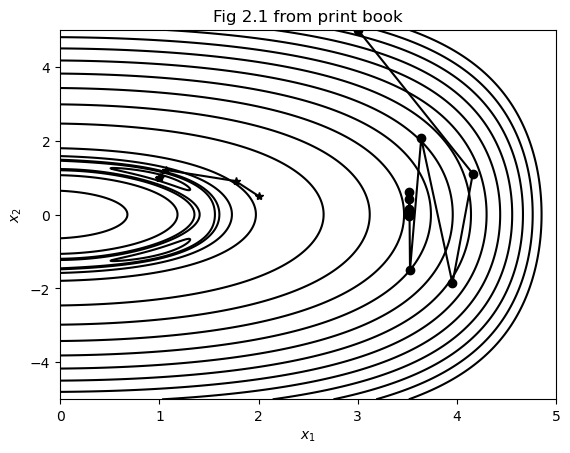

The line search failed at iteration 15
Termination with failure
Current values: maxit  =  20, armmax = 10
Give the history array a look to see what's happening.
  


In [2]:
TwoDexample();

### Section 2.7.2: Chandrasekhar H Equation

The Chandrasekhar H-equation 
<cite data-cite="chand"><a href="siamfa.html#chand">(Cha60)</cite>,
<cite data-cite="busb"><a href="siamfa.html#busb">(Bus60)</cite> is
    
\begin{equation}
F(H)(\mu) =
H(\mu) - \left(1 - \dfrac{c}{2} \int_0^1
\dfrac{\mu H(\nu) \, d\nu}{\mu + \nu} \right)^{-1}
= 0.
\end{equation}
    
This equation arises in radiative transfer.

This equation has a well-understood dependence on the parameter $c$
<cite data-cite="twm68"><a href="siamfa.html#twm68">(Mul68)</cite>,
<cite data-cite="ctk:n1"><a href="siamfa.html#ctk:n1">(DK80)</cite>.
The equation has unique solutions at $c=0$
and $c=1$ and two solutions for $0 < c < 1$. There is a simple fold
singularity 
<cite data-cite="herb"><a href="siamfa.html#herb">(Kel87)</cite>    
at $c=1$. Only one 
<cite data-cite="chand"><a href="siamfa.html#chand">(Cha60)</cite>,
<cite data-cite="busb"><a href="siamfa.html#busb">(Bus60)</cite>,
of the two solutions for $0 < c < 1$ is of physical interest
and that is the one easiest to find numerically. One must perform
a continuation computation to find the other one, which we do in 
[Chapter5](SIAMFANLCh5.ipynb).
    
The structure of the singularity is preserved if one discretizes
the integral with any quadrature rule with positive weights
that integrates constants exactly. This fact enables one to readily
understand the behavior of nonlinear solvers.
    
We will approximate the integrals by the composite midpoint rule:
    
$$
\int_0^1 f(\mu) \, d\mu \approx \frac{1}{N} \sum_{j=1}^N f(\mu_j),
$$
    
where $\mu_i = (i - 1/2)/N$ for $1 \le i \le N$. The resulting discrete
problem is
    
\begin{equation}
\mf(\vx)_i =
x_i  - \left( 1 - \dfrac{c}{2N} \sum_{j=1}^N
\dfrac{\mu_i x_j}{\mu_i + \mu_j} \right)^{-1}.
\end{equation}

As is the case with most integral equations, increasing $N$
has no effect on the conditioning of the Jacobian
nor on the iteration statistics
<cite data-cite="ctk:globews"><a href="siamfa.html#ctk:globews">(KS91)</cite>,
<cite data-cite="allg"><a href="siamfa.html#allg">(ABPR86)</cite>.
Hence we
should observe that the iteration statistics are independent of $N$.

We will use the Fourier transform
approach from 
<cite data-cite="ctk:acta"><a href="siamfa.html#ctk:acta">(Kel18)</cite> and
<cite data-cite="ctk:sirev20"><a href="siamfa.html#ctk:sirev20">(Kel22)</cite>,
rather than the matrix-based approach from 
<cite data-cite="ctk:newton"><a href="siamfa.html#ctk:newton">(Kel03)</cite>.
One can simplify the approximate integral operator in the midpoint rule formula
and expose some useful structure. Since
    
$$
\frac{c}{2N} \sum_{j=1}^N \frac{x_j \mu_i}{\mu_j + \mu_i}
= \frac{c (i - 1/2) }{2N} \sum_{j=1}^N \frac{x_j}{i+j -1},
$$
    
the approximate integral operator is
the product of a diagonal matrix and a Hankel matrix and
one can use a fast Fourier transform to
evaluate the operator-vector product with $O(N \log(N))$
work 
<cite data-cite="golub"><a href="siamfa.html#golub">(GV96)</cite>,
<cite data-cite="ctk:acta"><a href="siamfa.html#ctk:acta">(Kel18)</cite>.
We use the Julia package
__FFTW.jl__
<cite data-cite="fftwjl"><a href="siamfa.html#fftwjl">(Joh20)</cite>.
The documentation for that package
and the paper 
<cite data-cite="FFTW05"><a href="siamfa.html#FFTW05">(FJ05)</cite> are very much worth reading.
    
We can express the approximation of the integral operator in matrix
form
    
$$
\mm(\vx)_{ij} = \frac{c (i - 1/2) }{2N} \sum_{j=1}^N \frac{x_j}{i+j -1}
$$
    
and compute the Jacobian analytically as
    
$$
\mf'(\vx) = \mi - \diag(\mg(\vx))^2 \mm
$$
    
where
    
\begin{equation}
\mg(\vx)_i = \left(
1  - \frac{c}{2N} \sum_{j=1}^N \frac{x_j \mu_i}{\mu_j + \mu_i}
\right)^{-1}.
\end{equation}
    
Hence the data for the Jacobian is already available after
one computes $\mf(\vx) = \vx - \mg(\vx)$ and the Jacobian can
be computed with $O(N^2)$ work.
We do that in this example and therefore the only part of the solve
that requires $O(N^3)$ work is the matrix factorization.
Of course, one can also approximate the Jacobian with finite differences
at a cost of $O(N^2 \log(N))$ work.

This is the first example of the need for
__precomputed data__. The file
__SIAMFANLEquations.jl/src/TestProblems/Systems/Hequation.jl__
not only
has the functions you need to evaluate the nonlinear residual and
Jacobian, but also the function __heqinit__, which initializes
the precomputed data. These data include
    

  - The output from {\bf plan\_fft!}, which initializes the data
for the FFT. Note the {\bf !}, this indicates that the FFT will overwrite
its input and save many allocations.
   
  - Vectors for the quadrature points and intermediate storage for
the Hankel matrix product.

  - The value of $c$, which you may change with the __setc!__ function. 
We do not list the lengthy source code for the module __Hequation.jl__.

The precomputed data saves a lot of time and keeps the code short and
organized. This book, like 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite> and
<cite data-cite="ctk:newton"><a href="siamfa.html#ctk:newton">(Kel03)</cite>       
strongly
advocates the use of precomputed data for linear and nonlinear solvers.
All of our solvers for systems of equations support the use of precomputed
data.

The Juila code __HeqSolutions.jl__ in the notebook solves the
H-equation with initial iterate $x_0 = (1, \dots, 1)^T$,
$\tau_a = \tau_r = 10^{-10}$, $N=100$. We compare the solutions
with $c=.5$ and $c=0.9$.
We use a finite difference Jacobian in this example. We will do a
more detailed comparison with an analytic Jacobian an single precision
linear algebra in __Section 2.8__.
The kwargs for the tolerances are the same as in the scalar
codes. The new thing is the kwarg for the precomputed data.
The keyword is ```pdata```.

```Julia
"""
HeqSolutions()
Draw Fig 2.2
"""
function HeqSolutions()
    n = 100
    c = 0.9
    x0 = ones(n)
    #
    #   Build the structure with the precomputed data.
    #
    hdata = heqinit(x0, c)
    #
    #   Allocate the room for the residual and Jacobian.
    #
    FS = ones(n)
    FPS = ones(n, n)
    #
    #   Call the solver twice.
    #
    nsolout9 = nsol(heqf!, x0, FS, FPS;
             rtol = 1.e-10, atol = 1.e-10, pdata = hdata, sham=1)
    #   Change c to .5
    setc!(hdata,.5)
    nsolout5 = nsol(heqf!, x0, FS, FPS;
             rtol = 1.e-10, atol = 1.e-10, pdata = hdata, sham=1)
    #
    # Showtime! Make the plot.
    #
    axis([0, 1.0, 1.0, 1.9])
    mu = hdata.mu
    H9 = nsolout9.solution
    H5 = nsolout5.solution
    plot(mu, H9, "k-", mu, H5, "k--")
    xlabel(L"\mu")
    ylabel(L"H(\mu)")
    legend(["c=.9", "c=.5"])
end
```

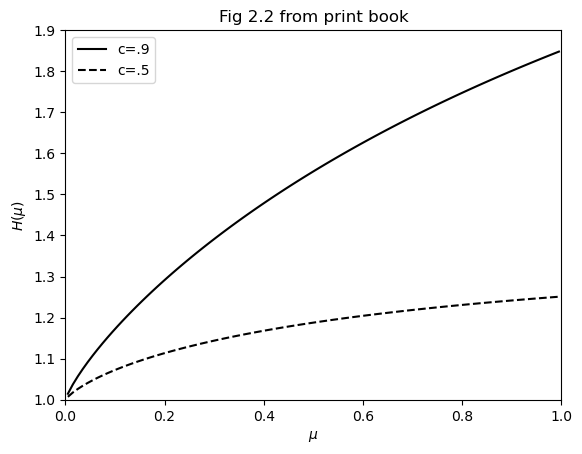

In [3]:
HeqSolutions();

### Section 2.7.3: A Two Point Boundary Value Problem

This example, an exercise from 
<cite data-cite="lindauri"><a href="siamfa.html#lindauri">(AP98)</cite>,
has a __banded Jacobian__. A banded matrix only has non-zero
elements on bands about the diagonal. So $\ma$ is banded with
upper bandwidth $m_u$ and lower bandwidth $m_l$ if $\ma_{ij} = 0$
unless
\[
i - m_l \le j  \le m_u + i.
\]
An LU or QR factorization of $\ma$ can reuse the storage allocated
for $\ma$ if one pads $\ma$ with two extra upper bands. We do that
in this application and use the QR factorization
```Julia
qr!(A)
```
The reason we use QR and not LU for banded matrices
is that QR, as of the date this book
was written, supports our mixed precision approach of doing linear
algebra in single precision and LU does not. This is likely to change.

We can use the fast band solvers from
LAPACK and Julia via the Julia package
__BandedMatrices.jl__ 
<cite data-cite="bandedjl"><a href="siamfa.html#bandedjl">(Olv20)</cite>.    
In this example it is
easy to compute the Jacobian analytically. Most of the Jacobian
is independent of the nonlinear iteration and we can store the data
for that in the precomputed data.

We seek $v \in C^2([0,20])$ such that
$$
v''(t) + (4/t) v'(t) + (t v(t) -1 )v(t) = 0; v'(0) = v(20) = 0.
$$
This problem has at least two solutions. One, $v = 0$, is not
interesting, so the objective is to find a nonzero solution.
    
We begin by converting the second order equation to a first-order system for
    
\begin{equation}
U =
\left( \begin{array}{c}
u_1 \\ u_2
\end{array} \right)
=
\left( \begin{array}{c}
v \\ v'
\end{array} \right).
\end{equation}
    
The equation for $U$ is
    
\begin{equation}
U'(t) =
\left( \begin{array}{c}
u_1(t) \\ u_2 (t)
\end{array} \right)'
= G(t,U(t)) =
\left( \begin{array}{c}
u_2(t) \\ - (4/t) u_2 (t) - (t u_1(t) -1 )u_1(t)
\end{array} \right).
\end{equation}
    
We will discretize the problem on an equally spaced mesh 
$\{ t_i \}_{i=1}^N$, where $t_i = (i - 1) dt$ and $dt = 20/(N-1)$.
Letting $U_i \approx U(t_i)$,
we can express the problem for $\{ U_i \}_{i=1}^N$
as a nonlinear equation
$\mf (\vx) = 0$ with a banded Jacobian of upper and lower bandwidth two by
grouping the unknowns at the same point on the mesh:
    
$$
\vx = (U_1^T, U_2^T, \dots, U_N^T)^T.
$$
    
In this way $x_{2i +1} \approx v(t_i)$ and $x_{2i} \approx v'(t_i)$.
The boundary conditions are the first and last equations
    
$$
\mf(\vx)_1 = x_2 = 0 \mbox{ and } \mf(\vx)_{2N} = x_{2N -1} = 0.
$$
$u_1' = u_2$ is expressed in the odd components of $F$ as
    
$$
\mf(\vx)_{2i+1} = x_{2i+1} - x_{2i -1} - (h/2) (x_{2i} + x_{2i +2})
$$
for $1 \le i \le N-1$.   
    
The even components of $F$ are the discretization
of the original differential equation

$$
\mf(\vx)_{2i} = x_{2i+2} - x_{2i}
+(h/2) (\Phi_{i+1}(\vx) + \Phi_{i}(\vx)), 1\le i \le N-1.
$$
    
Here
    
$$
\Phi_i(x) = (4 t_i^\dagger) x_{2i} + (t_i x_{2i-1} -1 ) x_{2i -1}
$$
    
and
    
\begin{equation}
t^\dagger = \left\{ \begin{array}{ll}
1/t & \mbox{ if $t > 0$, }\\
0   & \mbox{ if $t = 0$.}
\end{array}
\right.
\end{equation}
    
If we organize $\vx$ in this way, we can split $\mf$ into linear and
nonlinear parts

$$
\mf(\vx) = \md \vx + \mP(\vx), \mbox{ where }
$$
    
$$
(\md \vx)_1 = x_2, \mbox{ and } (\md \vx)_{2N} = x_{2N-1}
$$
    
and for $i=1, \dots, N-1$

\begin{equation}
\begin{array}{ll}
(\md \vx)_{2i+1} & = x_{2i+1} - x_{2i -1} - (h/2) (x_{2i} + x_{2i +2}) \\
(\md \vx)_{2i} & = x_{2i+2} - x_{2i}.
\end{array}
\end{equation}
    
The nonlinear term is,

\begin{equation}
\begin{array}{ll}
(\mP(\vx))_{2i+1}  = 0 & \mbox{ for $i = 0, \dots, N$} \\
(\mP(\vx))_{2i}  = (h/2) (\Phi_{i+1}(\vx) + \Phi_{i}(\vx))
& \mbox{ for $i = 0, \dots, N-1$}
\end{array}
\end{equation}

The Jacobian is __banded__.
It is easy to see from the formula for $\mf$ that $\mf'$ is banded with
$bu = bl = 2$. Moreover, only the even rows of $\mf'$ depend on $\vx$.
Hence one can store $\md$ in the precomputed data and only have to
differentiate $\mP$ with each iteration.
    
The astute reader will notice (or remember) that the function $U \equiv 0$ is a solution
of the problem.
If you change the initial iterate in our example, you
may well converge to the zero solution.
We can find a nonzero solution using the initial iterate
    
$$
v(t) = e^{-t^2/10} \mbox{ and } v'(t) = -t e^{-t^2/10}/5.
$$
    
The solver struggles, with the line search being active for three
of the nine iterations.
We plot that solution in __Figure 2.3__.



The file __Fvpb!.jl__ in __src/TestProblems/Systems__ contains the
evaluation of the function and Jacobian for this problem as well as
a function to initialize the precomputed data. We store the Jacobian
as a banded matrix and use the __BandedMatrices.jl__
<cite data-cite="bandedjl"><a href="siamfa.html#bandedjl">(Olv20)</cite>
package.
The Juila code __BVPsolution.jl__ in the notebook solves the problem
with $N=801$ (so $h = 1/40$)
and creates the plot. The core function within
__BVPsolution.jl__ is {\bf bvp\_solve} from the examples.
__bvp\_solve.jl__
builds the initial iterate and solves the problem. The plotting
commands are very similar to those we use for the H-equation
problem in [Section 2.7.2](#Section-2.7.2:-Chandrasekhar-H-Equation)
and we omit those commands in
the listing for __bvp_solve__.
    
    
```Juila
"""
bvp_solve

Solve the boundary value problem to make Figure 2.3.
"""
function bvp_solve(n = 801, T = Float64)
    # set it up
    bdata = bvpinit(n, T)
    #
    U0 = zeros(2n)
    FV = zeros(2n)
    # BandedMatrix with the correct number of bands.
    FPV = bdata.JacS
    #
    # tv = 0:h:20 is the spatial mesh
    #
    tv = bdata.tv
    #
    # Build the initial iterate
    #
    sv = -.1 * tv .* tv
    v = exp.(sv)
    vp = -.2 * tv .* v
    U0[1:2:2n-1] = v
    U0[2:2:2n] = vp
    #
    # Call the solver. Jbvp! is my analytic Jacobian evaluation.
    #
    bvpout = nsol(Fbvp!, U0, FV, FPV, Jbvp!;
                   rtol = 1.e-10, pdata = bdata, sham=1, jfact=qr!)
    return (bvpout = bvpout, tv = tv)
end
```
    
The function __bvpinit__ allocates storage for the Jacobian as a
matrix with lower bandwidth $2$ and upper bandwidth $4$.
    
```Julia
FVP = BandedMatrix{T}(Zeros(2n, 2n), (2, 4))
```
    
Here ```T``` is the precision for storing the Jacobian. So if
the call to __bvp\_solve__ is
    
```Julia    
bvp_solve(801, Float32)
```

the Jacobian will be stored in single precision and the factorization
and linear solve will be done in single.
The solver
__nsol.jl__ uses qr to factor the Jacobian by default if the
matrix is banded. If you allocate the extra storage (and you should) then
set the __kwarg__ ```jfact``` to ```qr!``` as we did in __bvp\_solve__.

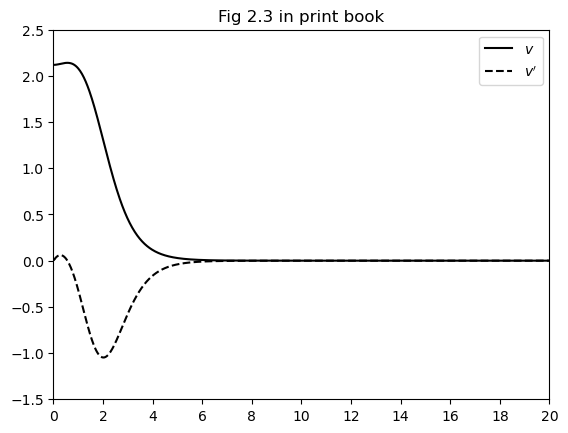

In [4]:
BVPsolution(801, Float64);

### Section 2.7.4: Stiff Initial Value Problems and the Buckling Beam

We will consider the problem for a beam under load
(see <cite data-cite="herb"><a href="siamfa.html#herb">(Kel87)</cite>)
and chapter 7 of 
<cite data-cite="elasticity"><a href="siamfa.html#elasticity">(MH83)</cite>).  
    
We apply $\ptc$ to this problem in the next section.
The time-dependent problem is
    
$$
u_t = u_{xx} + \lambda \sin(u)
$$

with boundary conditions
    
$$
u(0,t) = u(1,t) = 0 \mbox{ for all $0 < t \le 1$}
$$
    
and initial data
    
$$
u(x,0) =
x (1-x)(2-x) e^{-10 x (1-x)(2-x)}
\mbox{ for all $0 \le x \le 1$}.
$$
    
The initial data is nonnegative and, for $\lambda > \pi^2$,
close to the unstable steady
state $u \equiv 0$.
As you will see in the next section, we need to think about the
parameter $\lambda$ to get something interesting. The
choice $\lambda=20$ will work fine.

The steady-state problem

$$
u_{xx} + \lambda \sin(u), u(0) = u(1) = 0 
$$

is another example of a pitchfork bifurcation.
figure below (Fig 2.4 in the print book), taken from Ch 7 of 
<cite data-cite="elasticity"><a href="siamfa.html#elasticity">(MH83)</cite>).
illustrates the application and the pitchfork far more vividly
than any computer-generated figure could.
    
![Fig2.4](Images/Old_Figure.png)
    
Note that the point $\lambda_c = \pi^2$ is where the bifurcation takes place.

#### Time-accurate Integration

Nonlinear solvers are important parts of codes for
__stiff initial value problems__. In general terms
<cite data-cite="lindauri"><a href="siamfa.html#lindauri">(AP98)</cite>,
<cite data-cite="shampine80"><a href="siamfa.html#shampine80">(Sha80)</cite>,
<cite data-cite="shampinebook"><a href="siamfa.html#shampinebook">(Sha94)</cite>,
stiffness means that either implicit methods must be used to integrate in
time or, in the case of an explicit method,
very small time steps must be taken.

If the problem is nonlinear, a nonlinear solver must be used
at each time step. The most elementary example is the implicit
Euler method. To solve the initial value problem

$$
\vu' = \mg(\vu), \vu(0) = \vu^0
$$
    
with the implicit Euler method,
we specify a time step $\delta_t$ and approximate
the value of the solution at the mesh point $n \delta_t$ by $\vu^n$, where
$\vu^n$ solves the nonlinear equation

$$
\vu^n = \vu^{n-1} + \delta_t \mg(\vu^n).
$$

The nonlinear solver is given the function
    
$$
\mf(\vw) = \vw - \vu^{n-1} - \delta_t \mg(\vw)
$$
    
and an initial iterate. The initial iterate is usually either
$\vw_0 = \vu^{n-1}$ or a linear predictor
$\vw_0 = 2 \vu^{n-1} - \vu^{n-2}$. In many
codes 
<cite data-cite="lindauri"><a href="siamfa.html#lindauri">(AP98)</cite>,
<cite data-cite="lsode"><a href="siamfa.html#lsode">(RH93)</cite>,
<cite data-cite="slc"><a href="siamfa.html#slc">(BCP96)</cite>,
the termination criterion
is based on small step lengths (see __Section 1.5__).
This eliminates the need to evaluate the function
only to verify a termination condition. Similarly, the Jacobian is
updated very infrequently---rarely at every time step and certainly
not at every nonlinear iteration. This combination can lead to
problems if the Jacobian is ill-conditioned and varies rapidly
with time
<cite data-cite="ctk:mike2"><a href="siamfa.html#ctk:mike2">(KMT98)</cite>, 
but is usually very robust.
The time step $\delta_t$ depends on $n$ in any modern initial value problem
code. Hence the solver sees a different function
(varying $\vu^{n-1}$ and
$\delta_t$) at each time step. We refer the reader to the literature
<cite data-cite="lindauri"><a href="siamfa.html#lindauri">(AP98)</cite>,
<cite data-cite="shampine80"><a href="siamfa.html#shampine80">(Sha80)</cite>,
<cite data-cite="shampinebook"><a href="siamfa.html#shampinebook">(Sha94)</cite>,        
for
a complete account of how nonlinear solvers are managed in
initial value problem codes and focus here on a very basic
example. Here we update the Jacobian at each time step and use the
chord method for the nonlinear iteration at each time step.
    
We solve the initial value problem for \eqnok{pde1} on a spatial mesh
with width $\delta_x=1/64$ and use a time step
of $\delta_t=0.01$. The unknowns are approximations to $u(x_i,t_n)$ for
the interior nodes $\{ x_i \}_{i=1}^{63} = \{ i \delta_x \}_{i=1}^{63}$
and times $\{ t_i \}_{i=1}^{200} = \{ i \delta_t \}_{i=1}^{200}$.
Our discretization in space is the standard central difference
approximation to the second derivative with homogeneous Dirichlet
boundary conditions. The discretized problem is a stiff system of
63 ordinary differential equations. Typically implicit methods are
used for such systems 
<cite data-cite="lindauri"><a href="siamfa.html#lindauri">(AP98)</cite>,
<cite data-cite="shampine80"><a href="siamfa.html#shampine80">(Sha80)</cite>,
<cite data-cite="shampinebook"><a href="siamfa.html#shampinebook">(Sha94)</cite>.         
The simple
backward Euler method well illustrates the issues for nonlinear
solvers.

For a given time step $n$ and time increment $\delta_t$, the
components of the function $\mf$ sent to __nsol.jl__ are given by
    
$$
(\mf(\vw))_i = w_i - u^{n-1}_i +
 \delta_t ( \lambda \sin(w_i) +  (\md_2 \vw)_i)
$$
    
for $1 \le i \le N = 63$. The discrete second derivative $D_2$ is
the tridiagonal matrix with $-2$ along the diagonal and $1$ along
the sub- and superdiagonals.

This problem has the same structure as the boundary problem in the previous section.
The Jacobian is the sum of a linear operator
that is independent of $\vw$ and a nonlinear part. The nonlinear part
of this problem is particularly simple, a substitution operator,
and has a diagonal Jacobian.

In __Figure 2.5__ we plot the temporal history of the integration.
As time increases $u(x,t)$ approaches the stable steady-state
solution. The function __beamtimedep.jl__ from
__Notebook/src/Chapter__ generated the figure. __beamtimedep.jl__
uses the code for the example problem __src/Examples/ivpBeam.jl__. At the end of
the integration the norm of the residual was $\approx 2 \times 10^{-9}$.


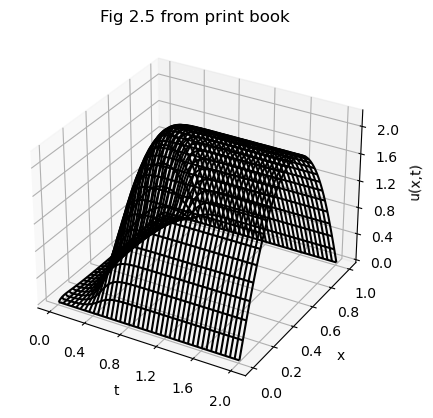

In [5]:
beamtimedep();

#### Convection-Diffusion Equation

This is an example from 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
<cite data-cite="ctk:newton"><a href="siamfa.html#ctk:newton">(Kel03)</cite>
of a semilinear
(i.e., linear in the highest order derivative)
elliptic partial
differential equation (PDE). This will show how to use the general
sparse matrix
data structure in Julia.

The problem is
$$
-\nabla^2 u + 20 u ( u_x + u_y) = f
$$
with homogeneous Dirichlet boundary conditions
on the unit square $(0,1) \times (0,1)$. Here $\nabla^2$ is the Laplacian
operator
$$
\nabla^2 = \dfrac{\partial^2}{\partial^2 x} + \dfrac{\partial^2}{\partial^2 y}.
$$
$f$ has been constructed so that
the exact solution is the discretization of
$$
u^*(x,y) = 10 x y (1-x) (1-y) \exp(x^{4.5}).
$$
We discretized on a uniform mesh with $31$ interior grid points
in each direction using centered differences and terminated the
with
$$
\tau_a = 10^{-10} \mbox{ and } \tau_r = 10^{-7}.
$$
The reader will get a wonderful opportunity to experiment with finer
grids in the notebook and in Chapter 3.
    
The physical grid is two-dimensional, but solvers expect one-dimensional
vectors. One can resolve this by ordering the unknowns and then forming
the matrix representations of the linear transformations. Juila's
sparse matrix data structure and sparse solvers
<cite data-cite="davisbook"><a href="siamfa.html#davisbook">(Dav06)</cite>,
<cite data-cite="umfpack"><a href="siamfa.html#umfpack">(Dav04)</cite>
from __SuiteSparse__ make this easy.
Use the Julia ```reshape``` command to
move between the two-dimensional
grid, which is useful for defining coefficient functions and plotting
the results, to the one dimensional grid for the solvers.

So if the two dimensional grid is $n \times n$. The the spatial mesh
width is $h=1/(n+1)$ and the grid points are $(x_i, x_j)$ where
$x_i = i*h$ for $1 \le i \le n$. There are $N=n^2$ unknowns and I will
order the grid points by varying the $x$ coordinate before the $y$
coordinate.  This means that
if the two dimensional data is $\vu^{2D}$, a $n \times n$ array where
$$
\vu^{2D}_{i,j} \approx u(x_i, x_j),
$$
then the vector one sends to the solvers uses the same storage and simply
is arranged as a vector $\vu$. The command for this is

```Julia
U=reshape(U2D,N).
```

One maps back to the two-dimensional grid with

```Julia
U2D=reshape(U,(n,n)).
```

Julia stores two dimensional arrays by columns. Our ordering means that
discretization of the partial derivative with respect to $x$
is sparse with the only nonzeros on the sub and superdiagonals. Similarly
the partial derivative with respect to $y$ is sparse with the only
nonzeros separated from the diagonal by $n$. The sparse matrix for
the discrete Laplacian has five nonzero bands, the diagonal and the
nonzero bands used by the first partial derivatives. We use the
Julia __spdiagm__ command to build these matrices. For example,
the code for the negative Laplacian is

```Julia
"""
Lap2d(n)

returns the negative Laplacian in two space dimensions
on n x n grid.

Unit square, homogeneous Dirichlet BC
"""
function Lap2d(n)
# hm2=1/h^2
hm2=(n+1.0)^2;
maindiag=fill(4*hm2,(n^2,));
sxdiag=fill(-hm2,(n^2-1,));
sydiag=fill(-hm2,(n^2-n,));
for iz=n:n:n^2-1
   sxdiag[iz]=0.0;
end
D2=spdiagm(-n => sydiag, -1 => sxdiag, 0=> maindiag,
             1 => sxdiag, n => sydiag);
return D2
end
```

One builds the sparse matrices
$\md_x$ for $\partial /\partial x$
and
$\md_y$ for $\partial /\partial y$
in a similar manner. The codes for these operators, which we will
use many times in this book, are in the file __PDE\_Tools.jl__ in
the __TestProblems/Systems__ directory.

One can express the discrete problem in terms of the
(precomputed!) sparse matrices for the differential operators as
    
$$
\mf(\vu) = \md_2 \vu + 20 \vu \cdot (\md_x + \md_y) \vu - \vf
$$
    
where the $\cdot$ denotes component-wise multiplication.
Using the very useful formula
    
$$
\mf'(\vu) \vw = \frac{d}{d \epsilon} \mf(\vu + \epsilon \vw)
\bigg|_{\epsilon=0},
$$
    
it is easy to see that
    
$$
\mf'(\vu) \vw = \md_2 \vw
+ 20 \vw \cdot (\md_x + \md_y) \vu
+ 20 \vu \cdot (\md_x + \md_y) \vw
$$
    
and therefore
    
$$
\mf'(\vu) =\md_2 +
20 \diag(\vu) (\md_x + \md_y) +
20 \diag((\md_x + \md_y) (\vu) ).
$$
    
The analytic Jacobian is sparse with five non-zero diagonals.
When we call __nsol.jl__ and allocate storage for the sparse
Jacobian, __nsol.jl__ will use the sparse solvers, with the
sparse $LU$ factorization as the default.
    
We store $\md_2$,
${\bf CV} =\md_x + \md_y$, and the right side $rhs=\vf$ in the
structure {\tt pdata} of precomputed data. The residual
evaluation function
(in __src/TestProblems/Systems/EllipticPDE.jl__)
is quite simple.

```Julia
"""
pdeF!(FV, u, pdata)

Residual using sparse matrix-vector multiplication
"""
function pdeF!(FV, u, pdata)
D2=pdata.D2
CV=pdata.CV
rhs=pdata.RHS
FV .= D2*u + 20.0*u.*(CV*u) - rhs
end
```

The Jacobian evaluation is tricky because one must think
about how to assemble the sparse matrix in order to avoid
expensive allocations. We invite the reader to look at the
function __pdeJ!__ in
__src/TestProblems/Systems/EllipticPDE.jl__ to see.
    
In __Figure 2.6__ we compare the residual histories for
Newton's method, which does a sparse matrix factorization at
every iteration, and the default Shamanskii method with $m=5$.
The Shamanskii iteration evaluates and factors the Jacobian only
twice and takes only two more nonlinear iterations than Newton. We
will see in the notebook how large that savings can be in the
context of a larger example of this problem.


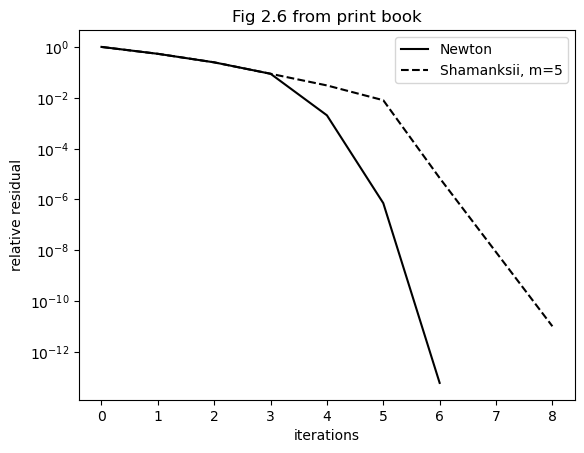

PyObject Text(0.5, 1.0, 'Fig 2.6 from print book')

In [6]:
pdech2()

#### Pseudo-transient continuation and the buckling beam

$\ptc$ confronts the same issues with direct solvers as the Newton-Armjo
iteration and the ideas are equally
applicable. Preallocation of storage, exploitation of structure,
and mixed precision are all important for $\ptc$.

In this section we will apply $\ptc$ to the steady-state buckling beam problem.
The code __ptcsol.jl__ requires
preallocation of storage for the function and Jacobian in the same way
that __nsol.jl__ does. We initialized $\ptc$ with $\delta_0 = .01$.

Our example problem __ptcBeam.jl__ uses the same initial data
and spatial grid that we used for the time-dependent problem.
The code compares
the results for $\ptc$ to Newton's method for the same initial data.
As you should expect, the $\ptc$ iteration converges to the positive
stable steady state and the Newton iteration converges to the unstable
zero solution. We use an analytic Jacobian. Our residual function
is __FBeam!.jl__ and the Jacobian is __BeamJ!.jl__. The functions are in 
the file __src/TestProblems/FBeam!.jl__.
The
precomputed data include the tridiagonal discrete Laplacian and
the grid points. The calls to __nsol.jl__ and __ptcsol.jl__
within __src/Examples/ptcBeam.jl__ are

```Julia
bout=ptcsol(FBeam!, u0, FS, FPS, BeamJ!;
             rtol=1.e-10, pdata=bdata, dt0=dt, maxit=maxit);
qout=nsol(FBeam!, u0, FS, FPS, BeamJ!; pdata=bdata, sham=1);
```

Note the similarities in the calling sequences.

We plot the residual histories in __Figure 2.7__.
$\ptc$ converged to the stable nonnegative steady-state in 24 steps
with a final residual norm of $\approx 7 \times 10^{-12}$. This is
a significant improvement over the direct integration to steady-state
in the previous section. The Newton iteration converged to the unstable
solution in only two iterations. As you can see, the residuals
are not monotone decreasing for $\ptc$. You should expect this because
the iteration must pass through transients before converging to
steady state.


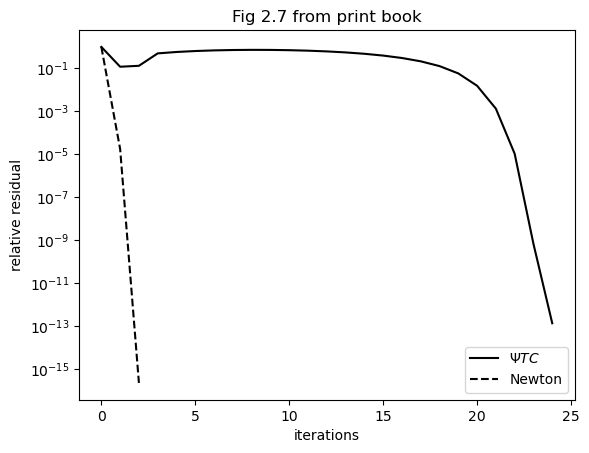

In [7]:
beamptc();

Our choices of $\delta_0 = .01$ and the spatial mesh width of
$\delta_x = 1/64$ are not independent. The Rosenbrock method is
explicit and therefore will become unstable if the initial pseudo-time step is too
large. In the context of $\ptc$ this means that,
for a fixed $\delta_x$, there is a limit to how large $\delta_0$ can
be if one wants to be certain to converge to the correct steady state
solution $\vu^* = \lim_{t \to \infty} \vu(t)$ of the initial value
problem. The condition that $\delta_0$ be sufficiently small is
serious. It should be clear to you that a choice of $\delta_0$ that
is extremely large will make the $\ptc$ iteration close to Newton's
method and thereby converge to the nearest solution, stable or not.

A more subtle problem is that choice of $\delta_0$ that is a bit too
large may cause the first step or two of Rosenbrock to leave the trajectory
for the stable steady state of interest. In that case the SER update for
$\delta$ will correct the stability, but you may then converge to a
different steady state. You can explore this in the project on this topic in __Section 2.9__.


## Next notebook = [Section 2.8: Solvers for Chapter 2](SIAMFANLCh2s.ipynb)